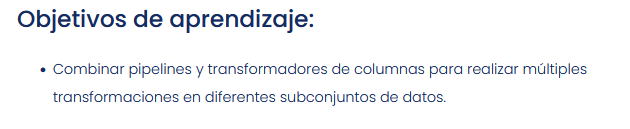

Los pipelines, selectores de columnas y transformadores de columnas y otros transformadores de preprocesamiento se pueden combinar juntos para realizar transformaciones complejas en diferentes subconjuntos de datos. Por ejemplo, pueden imputar y escalar datos numericos e imputar una codificacion one-hot en datos de objetos.

Los pipelines pueden ir dentro de ColumnTransformer para realizar una transformacion secuencial despues de dividir las columnas. Y los objetos ColumnTransformer pueden colocarse dentro de los pipelines. Pueden Lograr las transformaciones descritas anteriormente ya sea con un conjunto de ColumnTransformer en un pipeline o dos pipelines dentro de un ColumnTransformer. Hasta podrian poner un ColumnTransformer en un pipeline dentro de un ColumnTransformer dentro de un pipeline.

Como pueden observar, esto se puede volver un poco complicado, asi que puede ser util diagramar las transformaciones que quieren en los datos. Quieren imputar la mediana de los datos numericos, imputar la media de los datos flotantes, escalar ambos tipos, imputar datos de objetos con los valores mas frecuentes y luego realizar una codificacion one-hot?

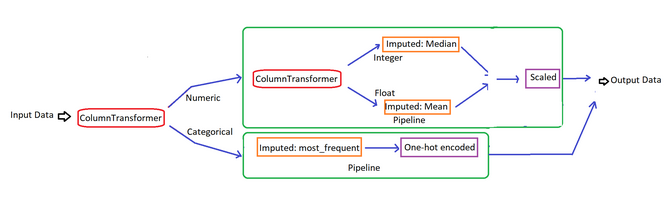

El diagrama anterior usa un ColumnTransformer con dos pipelines dentro. Uno de esos pipelines tambien tiene un ColumnTransformer dentro, De hecho, cuando estemos listos para usar esto para modelar, pondremos todo este objeto de preprocesamiento dentro de Otro pipeline con el modelo, al final de el.

# Ejemplo en codigo

En este ejemplo, tomaremos los datos con datos ordinales, categoricos, nominales y numericos. Hya datos que faltan, y los datos numericos necesitan ser escalados.

Usaremos dos pipelines, uno para el numerico y el otro para el categorico, y los pondremos en un transformador de columna. Tambien codificaremos ordinalmente una columna antes de dividir los datos. Ninguno de los datos faltantes es un tipo de numero entero.

El diagrama se ve asi.

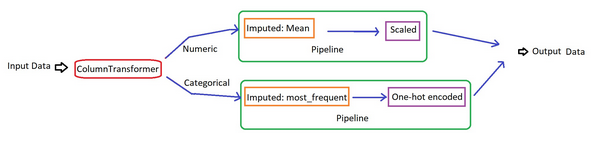

# Caso de modelado

Usaremos datos con respecto a las visitas del hospital. Estos datos contienen datos sobre los pacientes y sus condiciones de salud y acciones durante la estadia.

el objetivo de la modelizacion posterior sera predecir los cargos adicionales en los que incurriran

# pasos del proceso:

1. Importar las bibliotecas necesarios.
2. Cargar los datos.
3. Explorar los datos.
4. Division de validacion.
5. Instanciar selectores de columnas
6. Instanciar transformadores.
7. Instanciar pipelines.
8. Instanciar ColumnTransformer.
9. Transformar datos.
10. Inspeccionar los resultados.

# 1. Importar bibliotecas

In [1]:
# imports
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn import set_config
set_config(display='diagram')

#2. Cargar los datos

In [2]:
# Import the data
path = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vSzb_CfjmApDMSXRn-Ga8X5rgoRVm7U_UNYotqQ0iW2JVx1qoKFr41XOA-FNKPqds83B0oUM6zKtLqK/pub?output=csv'
df = pd.read_csv(path)
df.head()



,State,Lat,Lng,Area,Children,Age,Income,Marital,Gender,ReAdmis,...,Hyperlipidemia,BackPain,Anxiety,Allergic_rhinitis,Reflux_esophagitis,Asthma,Services,Initial_days,TotalCharge,Additional_charges
0,AL,34.34960,-86.72508,Suburban,1.0,53,86575.93,Divorced,Male,0,...,0.0,1.0,1.0,1.0,0,1,Blood Work,10.585770,3726.702860,17939.403420
1,FL,30.84513,-85.22907,Urban,3.0,51,46805.99,Married,Female,0,...,0.0,0.0,0.0,0.0,1,0,Intravenous,15.129562,4193.190458,17612.998120
2,SD,43.54321,-96.63772,Suburban,3.0,53,14370.14,Widowed,Female,0,...,0.0,0.0,0.0,0.0,0,0,Blood Work,4.772177,2434.234222,17505.192460
3,MN,43.89744,-93.51479,Suburban,0.0,78,39741.49,Married,Male,0,...,0.0,0.0,0.0,0.0,1,1,Blood Work,1.714879,2127.830423,12993.437350
4,VA,37.59894,-76.88958,Rural,1.0,22,1209.56,Widowed,Female,0,...,1.0,0.0,0.0,1.0,0,0,CT Scan,1.254807,2113.073274,3716.525786


#3. Explorar los datos

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 32 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   State               995 non-null    object 
 1   Lat                 1000 non-null   float64
 2   Lng                 1000 non-null   float64
 3   Area                995 non-null    object 
 4   Children            993 non-null    float64
 5   Age                 1000 non-null   int64  
 6   Income              1000 non-null   float64
 7   Marital             995 non-null    object 
 8   Gender              995 non-null    object 
 9   ReAdmis             1000 non-null   int64  
 10  VitD_levels         1000 non-null   float64
 11  Doc_visits          1000 non-null   int64  
 12  Full_meals_eaten    1000 non-null   int64  
 13  vitD_supp           1000 non-null   int64  
 14  Soft_drink          1000 non-null   int64  
 15  Initial_admin       995 non-null    object 
 16  HighBlo

#3b. Codificacion ordinal

podemos codificar datos de forma ordinal sin demasiado riesgo de fuga de datos.Generalmente son un numero pequeno de variables ordinales y es probable que esten en datos de entrenamiento y de prueba. Si ese no es el caso, el transformador skelearn llamado OrdinalEncoder se puede agregar a un pipeline de preprocesamiento.

In [4]:
df["Complication_risk"].value_counts()

Medium    459
High      311
Low       221
Med         4
Name: Complication_risk, dtype: int64

podemos ver que hay algunos valores incoherentes (Medium y Med). Podemos corregirlos en el mismo paso que codificamos de forma ordinal esta columna.

In [7]:
replacement_dictionary = {"High":2,"Medium":1,"Med":1,"Low":0}
df["Complication_risk"].replace(replacement_dictionary, inplace=True)
df["Complication_risk"]

0      1.0
1      2.0
2      1.0
3      1.0
4      0.0
      ... 
995    2.0
996    2.0
997    1.0
998    1.0
999    0.0
Name: Complication_risk, Length: 1000, dtype: float64

La columna "Complication_risk" es ahora un tipo de dato flotante y con codificacion ordinal.

#4. Division de la validacion

In [8]:
X = df.drop(columns="Additional_charges", axis=1)

y = df["Additional_charges"]

X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=42)

#5. Instanciar selectores de columnas

Crearemos nuestros selectores de columnas para usarlos con nuestro transformador de columna mas tarde. En su lugar, podemos utilizar listas de columnas, pero un selector de columna lo hace mas algoritmico. En este caso, el codigo seguira funcionando, incluso si las columnas en un DataFrame cambian despues que el pipeline se haya puesto en produccion.

In [9]:
# Selectores

cat_selector = make_column_selector(dtype_include="object")
num_selector = make_column_selector(dtype_include="number")

#6. Instanciar transformadores

Usaremos tres diferentes transformadores: SimpleImputer, StandardScaler, OneHotEncoder. 

Habra dos diferentes SimpleImputers con diferentes estrategias de imputacion:
"most_frequent" y "mean"

In [11]:
# imputers

freq_imputer = SimpleImputer(strategy="most_frequent")
mean_imputer = SimpleImputer(strategy="mean")

# scaler
scaler = StandardScaler()

# OneHotEncoder
ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)

#7. Instanciar pipelines

Usaremos dos diferentes pipelines.

Uno para los datos numericos

Uno para los datos nominales categoricos

In [12]:
numeric_pipe = make_pipeline(mean_imputer, scaler)
numeric_pipe

Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('standardscaler', StandardScaler())])

In [13]:
categorical_pipe = make_pipeline(freq_imputer, ohe)
categorical_pipe

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='most_frequent')),
                ('onehotencoder',
                 OneHotEncoder(handle_unknown='ignore', sparse=False))])

#8. Instanciar ColumnTransformer

make_column_transformer utiliza tuplas para hacer coincidir los transformadores con los tipos de datos sobre los que deben actuar.

Podemos usar pipelines como esos transformadores, que es lo que haremos a continuacion

In [14]:
# Tuples para Column Transformer
number_tuple = (numeric_pipe, num_selector)
category_tuple = (categorical_pipe, cat_selector)
# ColumnTransformer
preprocessor = make_column_transformer(number_tuple, category_tuple)
preprocessor



ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7efd0f0b9d00>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7efd0f0b9e50>)])

#9. Transformador de datos

Ajustaremos el ColumnTransformer, el cual se llamara "preprocessor" en los datos de entrenamiento. (Nunca en los datos de prueba).

In [15]:
# fit on train
preprocessor.fit(X_train)

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7efd0f0b9d00>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7efd0f0b9e50>)])

El metodo fit funciono para ajustar todos los 4 transformadores dentro de ColumnTransformer. Usaremos este ColumnTransformer ajustado para transformar nuestros conjuntos de datos de entrenamiento y de prueba.

In [16]:
# transform train and test
X_train_processed = preprocessor.transform(X_train)
X_test_processed = preprocessor.transform(X_test)

#10. Inspeccionar el resultado

Todos los transformadores Scikit-learn devuelven arrasy de numpy. Debido a esto debemos usar funciones como np.isnan(), para inspeccionar nuestros datos. En algunos casos podemos transformar facilmente nuestros datos devuelta a un dataframe de pandas, pero no siempre es facil obtener las columna de nombres devuelta. El OneHotEncoder crea columnas extras y es complicado recuperar los nombres de columnas correctos.

Nos aseguraremos que sustituyan los datos faltantes. que los datos categoricos realicen una codificacion one-hot y que los datos numericos se escalen.

In [17]:
# Comprueben los valores faltantes y que los datos se escalen y tengan una codificación one-hot
print(np.isnan(X_train_processed).sum().sum(), 'missing values in training data')
print(np.isnan(X_test_processed).sum().sum(), 'missing values in testing data')
print('\n')
print('All data in X_train_processed are', X_train_processed.dtype)
print('All data in X_test_processed are', X_test_processed.dtype)
print('\n')
print('shape of data is', X_train_processed.shape)
print('\n')
X_train_processed

0 missing values in training data
0 missing values in testing data


All data in X_train_processed are float64
All data in X_test_processed are float64


shape of data is (750, 97)




array([[-0.50820472,  0.28193545, -0.06527826, ...,  0.        ,
         1.        ,  0.        ],
       [-0.72064168,  0.25283631,  1.23912135, ...,  0.        ,
         0.        ,  0.        ],
       [-0.49340318,  0.48282262, -0.50007813, ...,  0.        ,
         1.        ,  0.        ],
       ...,
       [ 0.27295848,  0.63816773, -0.93487801, ...,  0.        ,
         0.        ,  0.        ],
       [-0.89653885, -1.73729615, -0.93487801, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.30727477,  1.1082109 , -0.93487801, ...,  0.        ,
         0.        ,  0.        ]])

Si bien no podemos ver todas las columnas aqui, observamos que no faltan datos, todos los datos estan en tipo float64 y que hay 97 columnas ahora, en lugar del orignal 32. es justo asumir que las columnas categoricas han realizado una codificacion one-hot.

# Resumen

El columnTransformer de Scikit-Learn y las clases de pipeline se pueden usar juntos para crear flujos de trabajo de preprocesamiento de datos complicados.

los pipelines procesan todas las columnas en secuencia, por otro lado, ColumnTransformer divide las columnas y transforma subconjuntos separados en paralelo. Podemos diagramar nuestros pasos de preprocesamiento deseados para tener una idea de como construir nuestro objeto de preprocesamiento.

este objeto final se puede usar para procesaro todos los datos a la vez. Tambien se puede poner en otro pipeline con un modelo para realizar un preprocesamiento y un modelado complejos en un solo paso.